<a href="https://colab.research.google.com/github/abhi123108/DeepFakeImageDetectionUsingDeepLearning/blob/main/FaceProof_Densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕵️‍♂️ FaceProof AI
### Deepfake Image Detection System

- Binary Classification: **Real vs Fake**
- Backbone: **DenseNet-121**
- Optimizer: **Adam**
- Epochs: **20**
- Metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC
- UI: **Gradio**


##1) Environment Setup


In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn matplotlib seaborn tqdm gradio


##2)Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##3)Global Paths

In [ ]:
import os

DATA_ROOT = "/content/drive/MyDrive/FaceProofAI"

UPLOAD_DIR = f"{DATA_ROOT}/uploads"
DATA_DIR   = f"{DATA_ROOT}/data"
CKPT_DIR   = f"{DATA_ROOT}/checkpoints"

print("UPLOAD_DIR:", UPLOAD_DIR)
print("DATA_DIR:", DATA_DIR)
print("CKPT_DIR:", CKPT_DIR)


UPLOAD_DIR: /content/drive/MyDrive/FaceProofAI/uploads
DATA_DIR: /content/drive/MyDrive/FaceProofAI/data
CKPT_DIR: /content/drive/MyDrive/FaceProofAI/checkpoints


##4)Create Project Folders  #


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/FaceProofAI"

folders = [
    f"{BASE_DIR}/uploads/real",
    f"{BASE_DIR}/uploads/fake",
    f"{BASE_DIR}/data/train/real",
    f"{BASE_DIR}/data/train/fake",
    f"{BASE_DIR}/data/val/real",
    f"{BASE_DIR}/data/val/fake",
    f"{BASE_DIR}/data/test/real",
    f"{BASE_DIR}/data/test/fake",
    f"{BASE_DIR}/checkpoints"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("Folder structure ready on Drive")

##5) Dataset Preparation   AUTO SPLIT CODE (RUN ONLY ONCE)
Uploaded images are automatically split into:
- **70% Training**
- **30% Validation and testing**



In [ ]:
import os, shutil, random

BASE_DIR = "/content/drive/MyDrive/FaceProofAI"


In [ ]:
for split in ["train", "val", "test"]:
    for cls in ["real", "fake"]:
        os.makedirs(f"{DATA_DIR}/{split}/{cls}", exist_ok=True)


In [ ]:
def split_images(class_name):
    src = f"{UPLOAD_DIR}/{class_name}"
    images = os.listdir(src)
    random.shuffle(images)

    n = len(images)
    train_end = int(0.7 * n)
    val_end   = int(0.85 * n)

    for i, img in enumerate(images):
        if i < train_end:
            split = "train"
        elif i < val_end:
            split = "val"
        else:
            split = "test"

        dst = f"{DATA_DIR}/{split}/{class_name}/{img}"
        if not os.path.exists(dst):
            shutil.copy(os.path.join(src, img), dst)


In [ ]:
if len(os.listdir(f"{DATA_DIR}/train/real")) == 0:
    split_images("real")
    split_images("fake")
    print(" Dataset split completed")
else:
    print(" Dataset already split — skipping")


 Dataset split completed


##6)Imports & Device

In [ ]:
import torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##7)Hyperparameters

In [ ]:
import os

DATA_ROOT = "/content/drive/MyDrive/FaceProofAI"

print("DATA_ROOT set to:", DATA_ROOT)


DATA_ROOT set to: /content/drive/MyDrive/FaceProofAI


In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4

CKPT_PATH = f"{DATA_ROOT}/checkpoints/faceproof_densenet.pth"

os.makedirs(f"{DATA_ROOT}/checkpoints", exist_ok=True)

print("Checkpoint will be saved at:")
print(CKPT_PATH)


Checkpoint will be saved at:
/content/drive/MyDrive/FaceProofAI/checkpoints/faceproof_densenet.pth


##8)Transforms (Anti-Overfitting)

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

##9)DataLoaders

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", train_tfms)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/val", test_tfms)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test", test_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
class_names


['fake', 'real']

In [ ]:
from collections import Counter

In [ ]:
def count_images(dataset, name):
    labels = [y for _, y in dataset.samples]
    c = Counter(labels)
    print(f"\n{name} set:")
    for k,v in c.items():
        print(f"{class_names[k]}: {v}")

count_images(train_ds, "TRAIN")
count_images(val_ds, "VAL")
count_images(test_ds, "TEST")



TRAIN set:
fake: 4908
real: 4904

VAL set:
fake: 1052
real: 1051

TEST set:
fake: 1052
real: 1052


##10)DenseNet-121 Model

In [ ]:
model = models.densenet121(weights="IMAGENET1K_V1")
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 215MB/s]


##11)Resume training

In [ ]:
import os
import torch

start_epoch = 0

if os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optim"])

    train_acc  = ckpt["train_acc"]
    val_acc    = ckpt["val_acc"]
    train_loss = ckpt["train_loss"]
    val_loss   = ckpt["val_loss"]

    start_epoch = ckpt["epoch"]

    print(f"Resuming from epoch {start_epoch}")
else:
    train_acc, val_acc, train_loss, val_loss = [], [], [], []



##12)Training Loop

In [ ]:
for epoch in range(start_epoch, EPOCHS):
    model.train()
    preds, labels, loss_sum = [], [], 0

    for x, y in tqdm(train_dl):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(y.cpu().numpy())

    epoch_train_acc = accuracy_score(labels, preds)
    epoch_train_loss = loss_sum / len(train_dl)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)

    # -------- Validation --------
    model.eval()
    vp, vl, vloss = [], [], 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x)
            vloss += criterion(out, y).item()
            vp.extend(out.argmax(1).cpu().numpy())
            vl.extend(y.cpu().numpy())

    epoch_val_acc = accuracy_score(vl, vp)
    epoch_val_loss = vloss / len(val_dl)

    val_acc.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)

    # -------- SAVE EVERYTHING --------
    torch.save({
        "epoch": epoch + 1,
        "model": model.state_dict(),
        "optim": optimizer.state_dict(),
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss
    }, CKPT_PATH)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"TrainAcc={epoch_train_acc:.3f} "
        f"ValAcc={epoch_val_acc:.3f}"
    )


100%|██████████| 307/307 [01:54<00:00,  2.69it/s]


Epoch 1/20 | TrainAcc=0.844 ValAcc=0.899


100%|██████████| 307/307 [01:52<00:00,  2.72it/s]


Epoch 2/20 | TrainAcc=0.924 ValAcc=0.885


100%|██████████| 307/307 [01:53<00:00,  2.71it/s]


Epoch 3/20 | TrainAcc=0.952 ValAcc=0.919


100%|██████████| 307/307 [01:54<00:00,  2.67it/s]


Epoch 4/20 | TrainAcc=0.967 ValAcc=0.924


100%|██████████| 307/307 [01:55<00:00,  2.66it/s]


Epoch 5/20 | TrainAcc=0.977 ValAcc=0.927


100%|██████████| 307/307 [01:54<00:00,  2.67it/s]


Epoch 6/20 | TrainAcc=0.980 ValAcc=0.920


100%|██████████| 307/307 [01:53<00:00,  2.71it/s]


Epoch 7/20 | TrainAcc=0.984 ValAcc=0.927


100%|██████████| 307/307 [01:53<00:00,  2.70it/s]


Epoch 8/20 | TrainAcc=0.982 ValAcc=0.910


100%|██████████| 307/307 [01:53<00:00,  2.71it/s]


Epoch 9/20 | TrainAcc=0.989 ValAcc=0.938


100%|██████████| 307/307 [01:52<00:00,  2.74it/s]


Epoch 10/20 | TrainAcc=0.988 ValAcc=0.915


100%|██████████| 307/307 [01:52<00:00,  2.73it/s]


Epoch 11/20 | TrainAcc=0.987 ValAcc=0.939


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch 12/20 | TrainAcc=0.991 ValAcc=0.922


100%|██████████| 307/307 [01:52<00:00,  2.73it/s]


Epoch 13/20 | TrainAcc=0.992 ValAcc=0.943


100%|██████████| 307/307 [01:52<00:00,  2.73it/s]


Epoch 14/20 | TrainAcc=0.994 ValAcc=0.939


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch 15/20 | TrainAcc=0.989 ValAcc=0.922


100%|██████████| 307/307 [01:50<00:00,  2.77it/s]


Epoch 16/20 | TrainAcc=0.993 ValAcc=0.941


100%|██████████| 307/307 [01:51<00:00,  2.75it/s]


Epoch 17/20 | TrainAcc=0.992 ValAcc=0.936


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch 18/20 | TrainAcc=0.993 ValAcc=0.931


100%|██████████| 307/307 [01:51<00:00,  2.75it/s]


Epoch 19/20 | TrainAcc=0.993 ValAcc=0.937


100%|██████████| 307/307 [01:51<00:00,  2.76it/s]


Epoch 20/20 | TrainAcc=0.989 ValAcc=0.931


##13)Load History + Plot Graphs

 Checkpoint + training history loaded


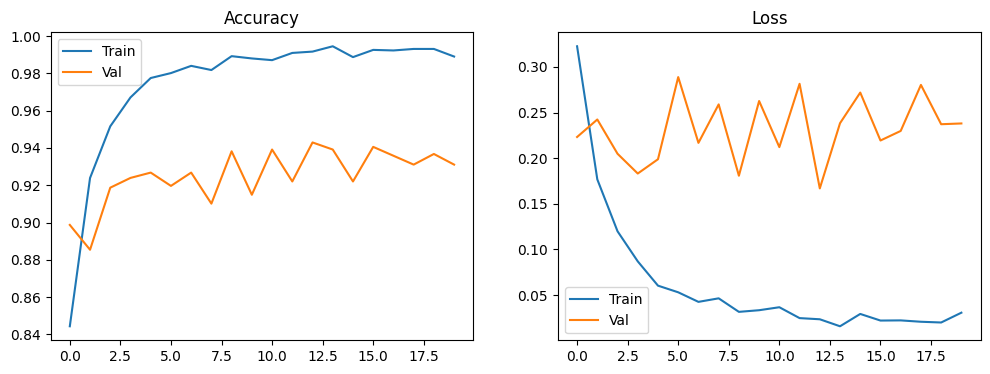

In [ ]:
import matplotlib.pyplot as plt

# -------- Load checkpoint + history --------
if os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location=device)

    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optim"])

    train_acc  = ckpt.get("train_acc", [])
    val_acc    = ckpt.get("val_acc", [])
    train_loss = ckpt.get("train_loss", [])
    val_loss   = ckpt.get("val_loss", [])

    print(" Checkpoint + training history loaded")
else:
    print(" Checkpoint not found")

# -------- Plot only if history exists --------
if len(train_acc) > 0:
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.title("Loss")
    plt.legend()

    plt.show()
else:
    print(" No training history found to plot")


##14)Test Metrics + ROC-AUC

In [ ]:
model.eval()
y_true,y_pred,y_prob = [],[],[]

with torch.no_grad():
    for x,y in test_dl:
        x = x.to(device)
        out = model(x)
        prob = torch.softmax(out,1)[:,1]
        y_prob.extend(prob.cpu().numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())

acc  = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred)
rec  = recall_score(y_true,y_pred)
f1   = f1_score(y_true,y_pred)

print("Accuracy:",acc)
print("Precision:",prec)
print("Recall:",rec)
print("F1:",f1)


Accuracy: 0.9372623574144486
Precision: 0.9509803921568627
Recall: 0.9220532319391636
F1: 0.9362934362934363


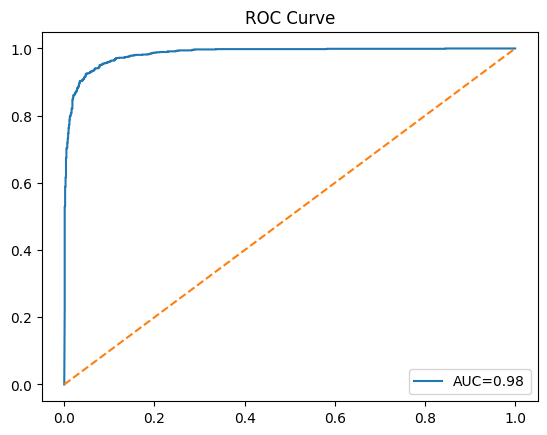

In [ ]:
fpr,tpr,_ = roc_curve(y_true,y_prob)
plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.show()


##15)Metrics Bar Graph

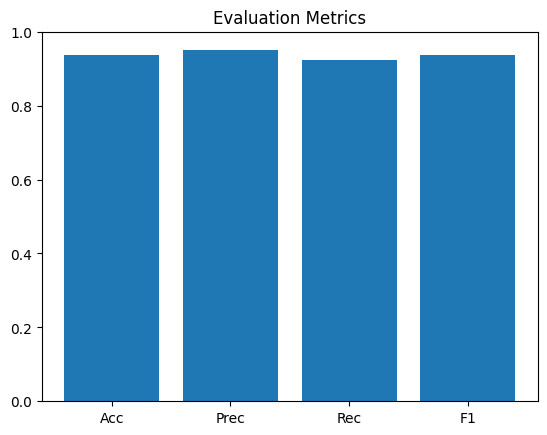

In [ ]:
plt.bar(["Acc","Prec","Rec","F1"],[acc,prec,rec,f1])
plt.ylim(0,1)
plt.title("Evaluation Metrics")
plt.show()


##16)📊 Confusion Matrix

<Figure size 500x500 with 0 Axes>

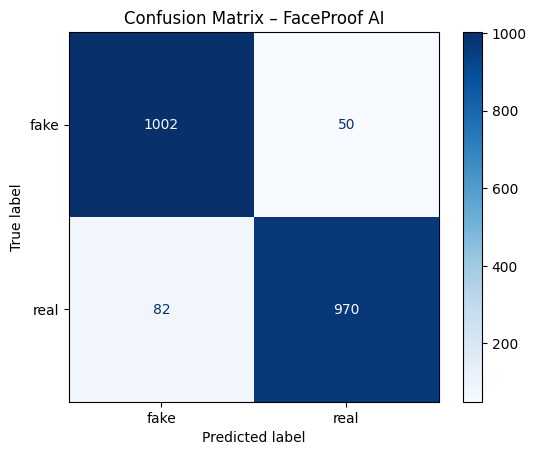

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions already computed? If not, recompute safely
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – FaceProof AI")
plt.show()


##17)Professional Gradio UI

In [ ]:
import gradio as gr

def predict(img):
    img = test_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img)
        probs = torch.softmax(out, dim=1)[0]

    return {
        class_names[1]: float(probs[1]),
        class_names[0]: float(probs[0])
    }

gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="🕵️‍♂️ FaceProof AI – DenseNet-121",
    description="Real vs Deepfake Face Detection"
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f145964354eacd5cc3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
